In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
import math
import scipy

import lib.linear_utils as lu
import lib.utils as utils

In [14]:
%matplotlib widget

In [57]:
seed=42

plot_args = {'lw':2, 'c':None, 'alpha':0.85}

n_basis = 2   # Number of sine waves per pattern
n_pats = 6    # Number of patterns
n_features = 1
pat_len = 10  # Length of each pattern

n_reps = 50                  # number of pattern repetitions in the signal

pat_rng = np.arange(0,1,1/pat_len)

freq_range = 60

cmap = cmr.get_sub_cmap('Set1', 0, 0.8, N=n_pats)

np.random.seed(seed=seed)
freq = np.random.rand(n_pats, n_basis, n_features) * freq_range + 1
phase = np.random.rand(n_pats, n_basis, n_features) * 2 * math.pi
mean_pat_len = np.random.randint(-2,4, n_pats) + pat_len

pat = np.zeros([n_pats, max(mean_pat_len), n_features])
for i in range(n_pats):
    pat_rng = np.arange(0,1,1/mean_pat_len[i])
    for j in range(n_features):
        for k in range(n_basis):
            pat[i,:mean_pat_len[i], j] += np.sin(pat_rng*freq[i,k,j]+phase[i,k,j])

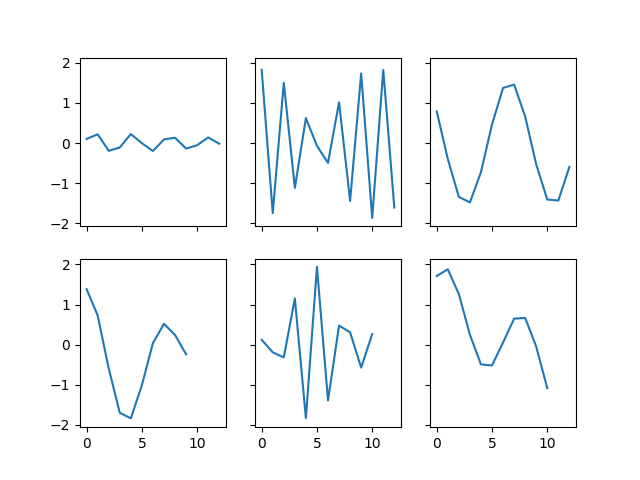

In [58]:
fig, ax = plt.subplots(nrows=2, ncols=len(pat)//2, squeeze=False, sharex=True, sharey=True)
ax = ax.flat
for i in range(n_pats):
    ax[i].plot(pat[i,:mean_pat_len[i]])

In [59]:
smooth_ratio = [3, 0.5]
noise_ratio = 0.2
variant_seq = np.random.randint(0,n_pats, n_reps)
variant_seq_len = mean_pat_len[variant_seq]
rep_array = pat[variant_seq]
variant_slope = np.random.default_rng().uniform(0.8, 1.2, n_reps)
variant_off = np.random.default_rng().uniform(-0.2, 0.2, n_reps)
variant_noise = np.random.normal(0, noise_ratio, rep_array.shape)
variant_len = list(map(lambda x,y: int(x/y[1]), variant_seq_len,zip(variant_off, variant_slope)))
total_len = np.sum(variant_len)

In [104]:
signal = np.zeros((total_len, n_features))
p = 0

warped_pats = {}
unwarped_pats = {}

ps = []

for i in range(n_reps):
    ps.append(p)
    temp = rep_array[i][:variant_seq_len[i]]
    
    if variant_seq[i] not in unwarped_pats.keys():
        unwarped_pats[variant_seq[i]] = [temp + variant_noise[i][:temp.shape[0]]]
    else:
        unwarped_pats[variant_seq[i]].append(temp + variant_noise[i][:temp.shape[0]])
    
    # I'm using crop=False to show the effect of knowing this parameter afterwards
    # as if I artificially crop my patterns I lose the information
    # and even using the exact inverse of the parameters will not be able to rvert to it
    # in real life, however, I'm using the offset for the windows precision. 
    temp = lu.warp_linear(temp, [variant_off[i], variant_slope[i]], crop=True)[0]
    signal[p:p+temp.shape[0]] = temp
    # signal.append(temp)
    p += temp.shape[0]
    
    # if variant_seq[i] not in warped_pats.keys():
    #     warped_pats[variant_seq[i]] = [temp + variant_noise[i][:,:temp.shape[1]]]
    # else:
    #     warped_pats[variant_seq[i]].append(temp + variant_noise[i][:,:temp.shape[1]])

ps.append(p)
ps = np.array(ps, dtype=np.double)
signal = signal[:p]
# signal = sig.convolve(signal, sig.gaussian(*smooth_ratio)/sum(sig.gaussian(*smooth_ratio)))

# Noise may be added
signal = signal + np.random.normal(0, noise_ratio, (signal.shape[0], n_features))

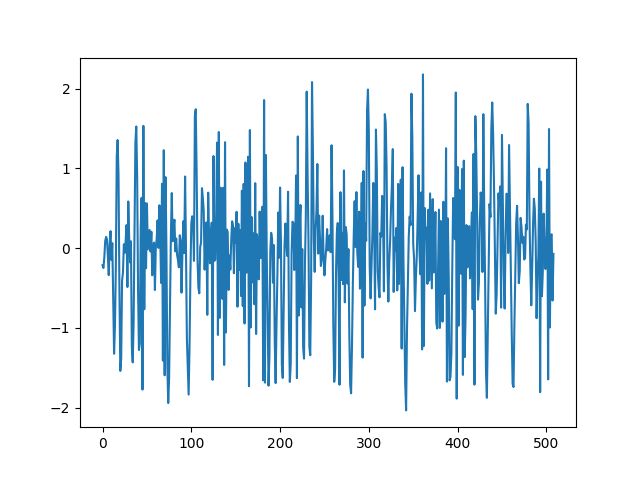

In [105]:
plt.figure()
plt.plot(signal)

(array([1., 0., 0., 2., 0., 0., 0., 0., 0., 3.]),
 array([10. , 10.3, 10.6, 10.9, 11.2, 11.5, 11.8, 12.1, 12.4, 12.7, 13. ]),
 <BarContainer object of 10 artists>)

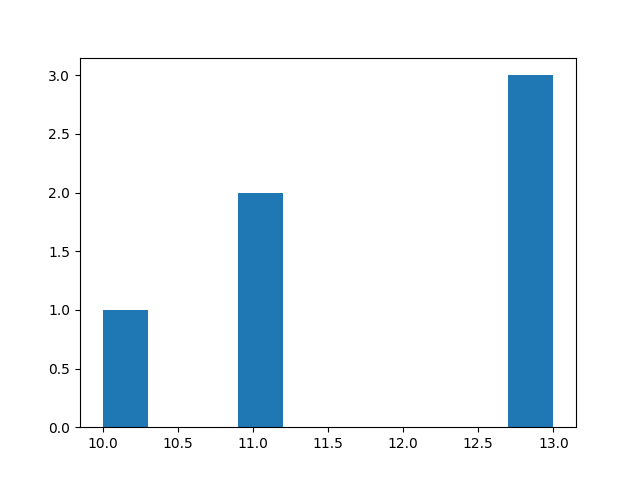

In [106]:
plt.figure()
plt.hist(mean_pat_len)

In [107]:
max(mean_pat_len)

13

In [63]:
data = {'XD': signal.T}

In [64]:
scipy.io.savemat('../our_synthetic_data.mat', data)

In [108]:
one_hot = np.eye(n_pats)[variant_seq]

In [115]:
ground_truth = {'s': np.squeeze(ps[:-1]+1), 'sH': np.squeeze(ps[:-1]+1), 'G': one_hot.T, 'acc': [], 'tim':[], 'obj': []}

In [116]:
scipy.io.savemat('../our_ground_truth.mat', ground_truth)